### Import Modules

In [1]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Activation, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dropout

# So we can see the output of multiple variables in a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.


### Load lines from CSV file and split Train/Test

In [2]:
# # Are you using AWS?
# # Are you using Ricky's driving data?
# aws = False
# ricky = False

# if aws:
#     csv_path = '/home/carnd/Udacity-Self-Driving-Car-NanoDegree/p3-behavioural-cloning' \
#                 '/carnd-behavioral-cloning-p3/data/driving_log.csv'
#     image_path = '/home/carnd/Udacity-Self-Driving-Car-NanoDegree/p3-behavioural-cloning' \
#                 '/carnd-behavioral-cloning-p3/data/IMG/'
# else:
#     if ricky:
#         csv_path = r"D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\ricky\turn-corrections\driving_log.csv"
#         image_path = r"D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\ricky\turn-corrections\IMG\\"
#     else:
#         csv_path = "D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\data\data\driving_log.csv"
#         image_path = "D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\data\data\IMG\\"

# lines = []
# with tqdm(open(csv_path)) as csvfile:
#     reader = csv.reader(csvfile)
#     next(reader, None);
#     for line in reader:
#         lines.append(line)
        
# # Check if our CSV list is empty
# assert len(lines) > 0
# assert len(lines[0]) == 7

# train_samples, validation_samples = train_test_split(lines, test_size=0.2)

In [3]:
#%load data-consolidation.py
'''
THE GOAL

1.) Take a peak at the folders that contain the driving data
2.) Consolidate all the CSV files into a single list
3.) We will NOT augment or trim down any of the data in this script

Format of list
[
    [part1, part2, ..., part7]
    <many rows here>
    [part1, part2, ..., part7]
]

'''

from os import walk, path
from time import time
from csv import reader


def consolidate(path_to_folders, print_verbose=True):

    path_to_files = []
    lines = []

    if print_verbose:
        for a, b, c in walk(path_to_folders):
            print('root-------')
            print(a, '\n')
            print('\tdirs-------')
            for dir in b:
                # Skip the IMG folders
                if 'IMG' in dir: continue
                # Create a complete path to each folder
                print('\t\t', dir)
            print('\t\t\tfiles-------')
            print('\t\t\tfile count = {}'.format(len(c)))
            [print('\t\t\t\t', (file)) for file in c if 'csv' in file]
            file = [file for file in c if 'csv' in file]

    # Create list of full csv file paths
    for a, b, c in walk(path_to_folders):
        for file in c:
            if 'csv' in file:
                path_to_files.append(path.join(a, file))

    # Append lines of every CSV file to the list lines
    for file in path_to_files:
        folder_to_parse = file.split('\\')[-2]
        
#         if 'udacity' in folder_to_parse: 
#             print('breaking')
#             break
            
        print('\nParsing \t\t==> {}'.format(folder_to_parse))

        start_time = time()
        with open(file, 'r', encoding='UTF-8') as csvfile:
            csv_reader = reader(csvfile)
            next(csv_reader, None)  # skip header
            
            for line in csv_reader:

#                     if (dice != 0): continue
#                 if (dice != 0) & (line[3] == '0'):
#                     continue
                    
                # rename the folder path since we have multiple folders (clockwise, corrections, etc.)
                # line[0] will be like this 'clockwise\\center.jpg'
                # line[1] will be like this 'clockwise\\left.jpg'
                line[0] = image_path + '\\' + folder_to_parse + '\\' + 'IMG\\' + line[0].split('\\')[-1]

                if 'udacity' in folder_to_parse:
                    dice = np.random.randint(0,6)
                    if ('0.00' in line[3]): 
                        if dice < 3:
                            break                    
                    line[0] = image_path + '\\' + folder_to_parse + '\\' + 'IMG\\' + line[0].split('/')[-1]
                    line[1] = image_path + '\\' + folder_to_parse + '\\' + 'IMG\\' + line[1].split('/')[-1]
                    line[2] = image_path + '\\' + folder_to_parse + '\\' + 'IMG\\' + line[2].split('/')[-1]

                lines.append(line)
        time_in_ms = (time()-start_time)*1000
        print('Length of Lines \t==> {}'.format(len(lines)))
        print('Done! Elapsed time(ms) \t==> {0:5.2f}'.format(time_in_ms))

    return lines

'\nTHE GOAL\n\n1.) Take a peak at the folders that contain the driving data\n2.) Consolidate all the CSV files into a single list\n3.) We will NOT augment or trim down any of the data in this script\n\nFormat of list\n[\n    [part1, part2, ..., part7]\n    <many rows here>\n    [part1, part2, ..., part7]\n]\n\n'

In [4]:
image_path = r'D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\ricky'
# lines[0]
lines = consolidate(image_path, print_verbose=False)
print('\nNumber of unprocessed images ==>\t', len(lines))
assert len(lines) > 0, "You've got no lines"
train_samples, validation_samples = train_test_split(lines, test_size=0.3)
for i in range(len(lines)):
    if lines[i][1] is not '':
        print('{}\n{}\n{}'.format(lines[i][0], lines[i][1], lines[i][2]));
    
    if i > 10: break



Parsing 		==> clockwise
Length of Lines 	==> 1252
Done! Elapsed time(ms) 	==>  5.00

Parsing 		==> counter-clockwise
Length of Lines 	==> 2028
Done! Elapsed time(ms) 	==>  5.00

Parsing 		==> extra-turns
Length of Lines 	==> 4444
Done! Elapsed time(ms) 	==> 92.06

Parsing 		==> turn-corrections
Length of Lines 	==> 4643
Done! Elapsed time(ms) 	==>  1.00

Parsing 		==> udacity
Length of Lines 	==> 5855
Done! Elapsed time(ms) 	==> 11.01

Number of unprocessed images ==>	 5855


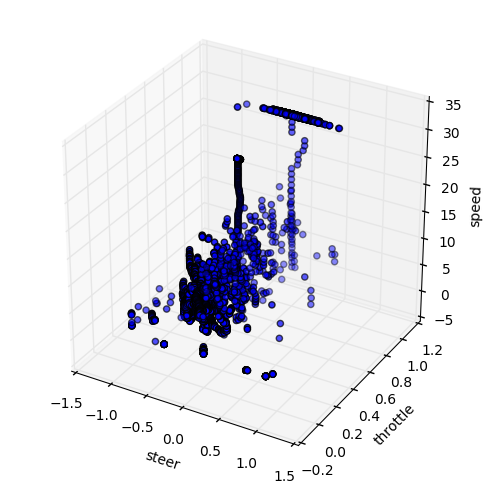

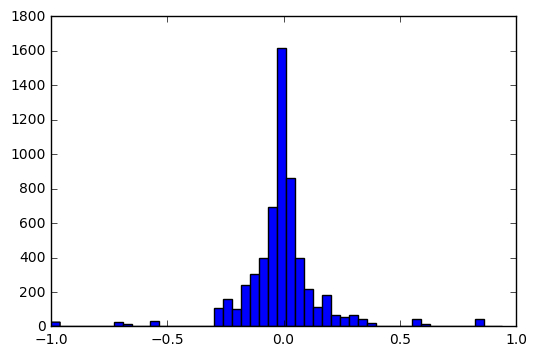

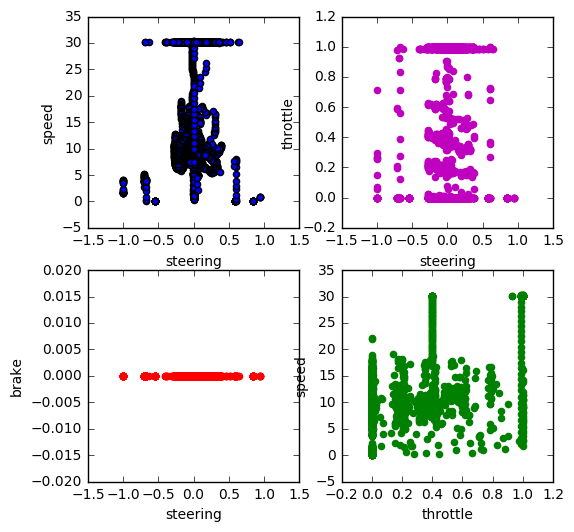

In [5]:
from mpl_toolkits.mplot3d import Axes3D

steer = [float(lines[x][3]) for x in range(len(lines))]
throttle = [float(lines[x][4]) for x in range(len(lines))]
brake = [float(lines[x][5]) for x in range(len(lines))]
speed = [float(lines[x][6]) for x in range(len(lines))]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(steer, throttle, speed)
ax.set_xlabel('steer')
ax.set_ylabel('throttle')
ax.set_zlabel('speed')
plt.show();

h, x, y = np.histogram2d(steer, throttle, bins=200)
plt.hist(steer, bins=50)
plt.show();


plt.figure(figsize=(6,6))

plt.subplot(221)
plt.scatter(steer, speed)
plt.xlabel('steering')
plt.ylabel('speed')

plt.subplot(222)
plt.scatter(steer, throttle, color='m')
plt.xlabel('steering')
plt.ylabel('throttle')

plt.subplot(223)
plt.scatter(steer, brake, color='r')
plt.xlabel('steering')
plt.ylabel('brake')

plt.subplot(224)
plt.scatter(throttle, speed, color='g')
plt.xlabel('throttle')
plt.ylabel('speed')


plt.show();

### Create Generator Function

In [23]:
rows, cols = 64, 64

def resize(img):
    return cv2.resize(img, (rows, cols), cv2.INTER_AREA)

def convert_to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def flip(img):
    return cv2.flip(img, 1)

def translate(img, steer, trans_amt):
    pass

def add_left_right_cameras(csv_line, angle, str_offset=0.25): 
#     if abs(angle) > 0.5 : exit
    
    left_pic = cv2.imread(csv_line[1])
    right_pic = cv2.imread(csv_line[2])
    
    assert left_pic !=None, 'Looks like you may have the wrong IMG destination{}'.format(csv_line[1])
    assert right_pic !=None, 'Looks like you may have the wrong IMG destination{}'.format(csv_line[2])
        
    new_angle_left_pic = angle + str_offset
    new_angle_right_pic = angle - str_offset
    
    return left_pic, new_angle_left_pic, right_pic, new_angle_right_pic

In [24]:
def generator(samples, batch_size=16):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            for batch_sample in batch_samples:

                image = cv2.imread(batch_sample[0])
                angle = float(batch_sample[3])
                
                assert image !=None, 'Looks like you may have the wrong IMG destination\n{batch}'.format(batch_sample[0])
                
                left_right = False
                dice = np.random.randint(0,2) # Select 1 in 3 udacity images
                if 'udacity' in batch_sample[0]:
#                     if dice == 0:
                    lf_pic, lf_ang, rt_pic, rt_ang = add_left_right_cameras(batch_sample, angle)
                    left_right = True
                
                # Process center camera
                image = convert_to_hsv(image)
                image = resize(image)
                # image.shape should be (320, 160, 1)
                # so we only train on the S channel of the HSV image
                images.append(image[...,1,None])
                angles.append(angle)
                
                # Flip images and steering angles
                image_flip = flip(image)
                images.append(image_flip[..., 1, None])
                angles.append(angle*-1.0)
                
                # Process Left camera
                if left_right:
                    lf_pic_hsv = convert_to_hsv(lf_pic)
                    lf_pic_resize = resize(lf_pic_hsv)
                    images.append(lf_pic_resize[...,1,None])
                    angles.append(lf_ang)
                
                # Process Right camera
                if left_right:
                    rt_pic_hsv = convert_to_hsv(rt_pic)
                    rt_pic_resize = resize(rt_pic_hsv)
                    images.append(rt_pic_resize[...,1,None])
                    angles.append(rt_ang)
                
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield shuffle(X_train, y_train)

### Plot Steering Angle Distribution

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


X shape (80, 64, 64, 1)
y.shape (80,)


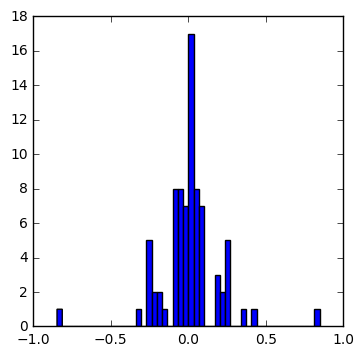

In [25]:
train_generator = generator(shuffle(train_samples), batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

X, y = next(train_generator)
print('X shape {}'.format(X.shape))
print('y.shape {}'.format(y.shape))

plt.figure(figsize=(4,4))
plt.hist(y, bins=50)
plt.show();

# X_sqz = np.squeeze(X)
# print('shape X_sqz', X_sqz.shape)
# plt.figure(figsize=(12,12))
# for i in range(len(X_sqz[0])):
#     plt.subplot(8, 8, i+1)
#     plt.imshow(X_sqz[i])
#     plt.title(i)
# plt.show();

In [414]:
# import plotly as py
# import plotly.graph_objs as go
# import plotly
# py.offline.init_notebook_mode(connected=True)

# trace = go.Scatter3d(
#     x = steer,
#     y = throttle,
#     z = myst,
#     mode = 'markers',
#     marker = dict(
#         opacity = 0.3,
#     )
# )
# data = [trace]
# layout = go.Layout(
#         xaxis = dict(
#             title = 'Steering Angle'
#     ),
#         yaxis = dict(
#             title = 'Throttle'
#     ),
#     showlegend = True
# )

# fig = go.Figure(data=data, layout=layout)
# py.offline.iplot(fig)

### Construct Model

In [26]:
# Model 3
model = Sequential()
model.add(Cropping2D(cropping=((14,5),(0,0)), input_shape=(64, 64, 1)))
model.add(Lambda(lambda x: x / 255.0 - 0.5))
model.add(Convolution2D(32, 5, 5, border_mode='same', name='conv1'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Convolution2D(64, 5, 5, border_mode='same', name='conv2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Convolution2D(128, 3, 3, border_mode='same', name='conv3'))
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(5,5)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(1))

### Train, Validate, and Save Model

In [27]:
model.compile(loss='mse', optimizer='adam')
# model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=5, batch_size=batch_size)

nb_val_samples = len(validation_samples)
nb_epoch = 3

# Complie modile with Generator
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples), \
                   validation_data=validation_generator, \
                   nb_val_samples=nb_val_samples, nb_epoch=nb_epoch, \
                   verbose=1)

model.save('model-ricky-jc-data.h5')
print('model {} saved'.format(model.__str__))

Epoch 1/3


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


4024/4098 [============================>.] - ETA: 0s - loss: 0.0432

C:\Program Files\Anaconda3\lib\site-packages\keras\engine\training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


4100/4098 [==============================] - 34s - loss: 0.0430 - val_loss: 0.0305
Epoch 2/3
4162/4098 [==============================] - 45s - loss: 0.0254 - val_loss: 0.0204
Epoch 3/3
4128/4098 [==============================] - 35s - loss: 0.0152 - val_loss: 0.0084
model <method-wrapper '__str__' of Sequential object at 0x000000D4800D6DA0> saved


### Analyze how well the model does

In [360]:
print(history_object.history.keys())

dict_keys(['val_loss', 'loss'])


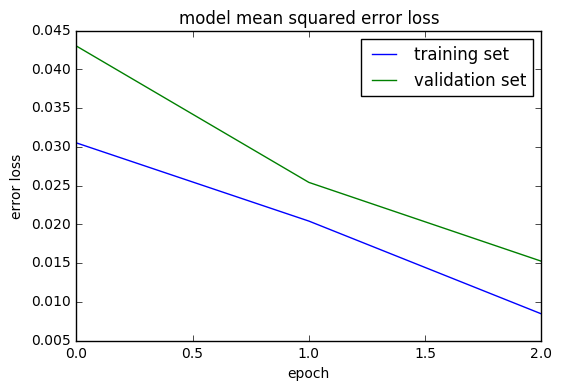

In [28]:
plt.plot(history_object.history['val_loss'])
plt.plot(history_object.history['loss'])
plt.title('model mean squared error loss')
plt.ylabel('error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

### Verify steering angle

In [363]:
X.shape
np.squeeze(X).shape

(64, 64, 64, 1)

(64, 64, 64)

(64, 64, 1)

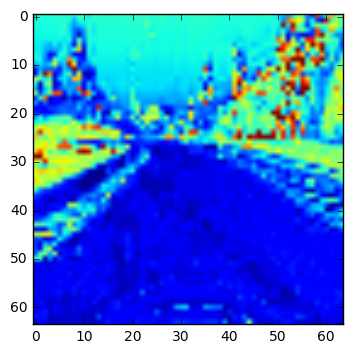

In [364]:
X[0].shape
X = np.squeeze(X)
plt.imshow(X[0])
plt.show()

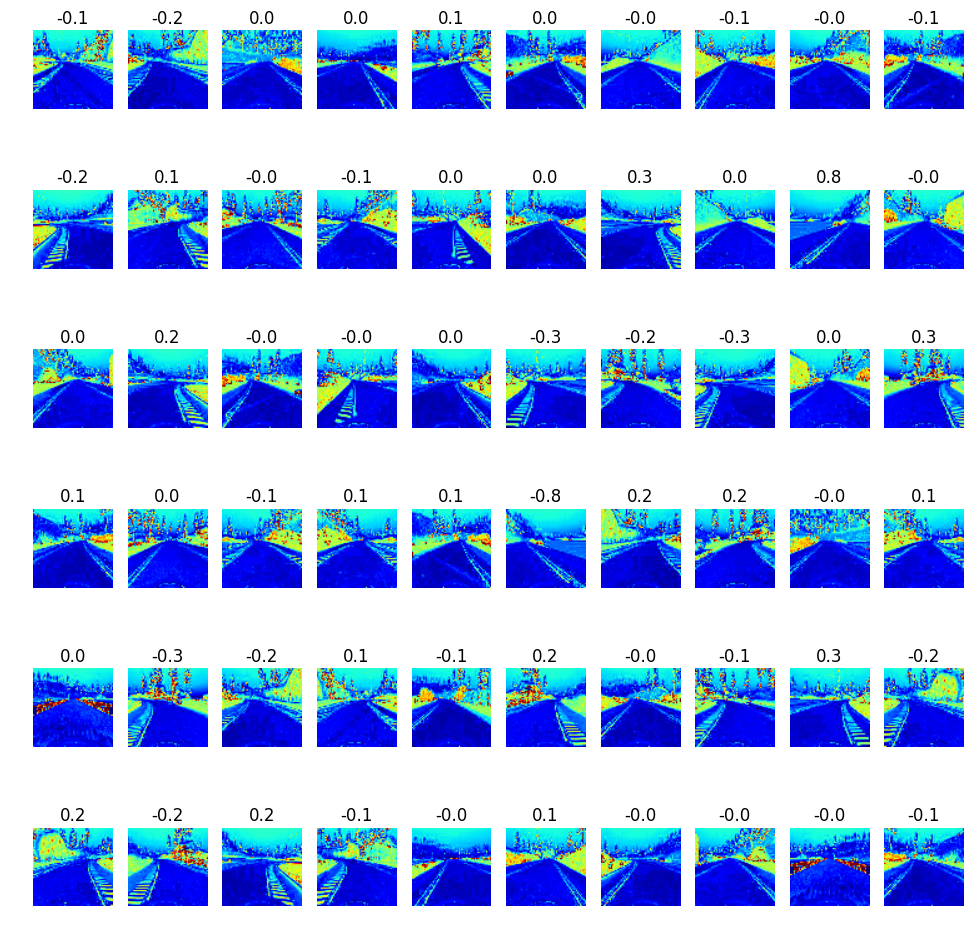

In [365]:
plt.figure(figsize=(12,12))
for i in range(60):
    plt.subplot(6,10,i+1)
    plt.imshow(X[i])
    plt.title('{:2.1f}'.format(y[i]))
    plt.axis('off')
#     plt.tight_layout()
plt.show();

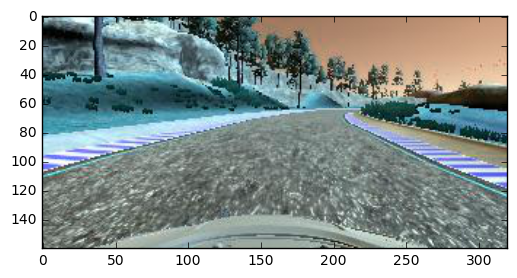

In [371]:
img = cv2.imread(r"D:\SDC\p3-Behavioural-Cloning\p3-behavorial-cloning\ricky\clockwise\IMG\center_2017_03_18_11_39_30_788.jpg")
img.shape
plt.imshow(img)
plt.show();

In [376]:
img = convert_to_hsv(img)
img = resize(img_hsv)
img_s = img[...,1,None]
img_s.shape

(64, 64, 1)

In [377]:
steering_angle = float(model.predict(img_s[None,...], batch_size=1))
steering_angle

0.1525983065366745

### Take a peak of the layer

In [378]:
layer1 = Model(input=model.input, output=model.get_layer('conv1').output)
layer2 = Model(input=model.input, output=model.get_layer('conv2').output)

visual_layer1 = layer1.predict(img_s[None, ...])
visual_layer2 = layer2.predict(img_s[None, ...])

In [379]:
visual_layer1.shape
visual_layer2.shape

arr_1, arr_2, layer_1, layer_2 = [], [], [], []
for i in range(32):
    arr_1.append(visual_layer1[0, :, :, i])
for i in range(64):
    arr_2.append(visual_layer2[0, :, :, i])

(1, 45, 64, 32)

(1, 15, 21, 64)

layer 1 feature map


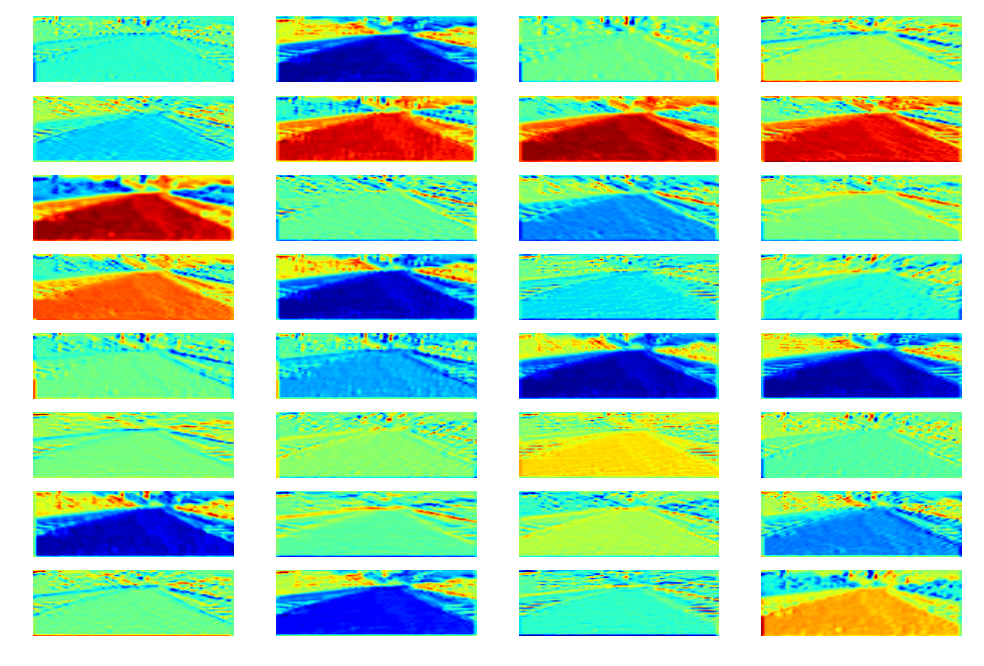

In [383]:
print("layer 1 feature map")

plt.figure(figsize=(12,8))
for i in range(32):
    plt.subplot(8, 4, i+1)
    temp = arr_1[i]
    temp = cv2.resize(temp, (200, 66), cv2.INTER_AREA)
    plt.imshow(cv2.applyColorMap(temp, cv2.COLORMAP_BONE))
    plt.axis('off')
plt.show();

layer 2 feature map


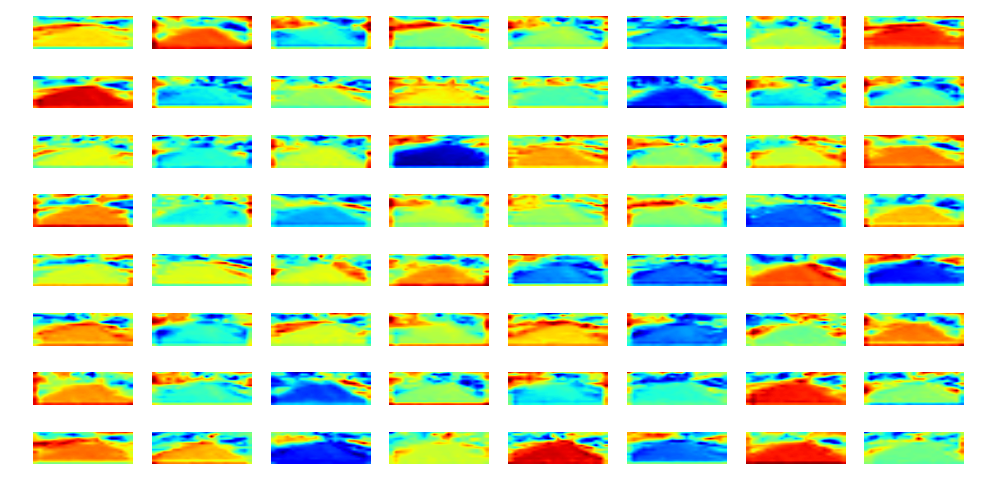

In [384]:
print("layer 2 feature map")

plt.figure(figsize=(12,6))
for i in range(64):
    plt.subplot(8, 8, i+1)
    temp = arr_2[i]
    temp = cv2.resize(temp, (200, 66), cv2.INTER_AREA)
    plt.imshow(cv2.applyColorMap(temp, cv2.COLORMAP_SUMMER))
    plt.axis('off')
plt.show();